### Introduction

Credit card transaction has been the primary form of payment for many consumers. Being able to detect and stop a fraudulent transaction is important to the cardholder’s security and the credit card company’s accountability. 

In fitting a fraud detection model, the nature of imbalance in the number of fraudulent versus normal transactions in the training data needs to be dealt with carefully in pre-processing the data.
In this project, xgboost models were used to predict whether a credit card transaction is fraudulent using a dataset containing transaction information. 

Re-balancing methods like random under-sampling, SMOTE, and cost-sensitive learning were used to balance the number of observations in each class. A grid search cross validation approach was used to determine the optimal values for the hyperparameters of interest.

The dataset used in this project was originally collected and analyzed in a collaborative research of Worldline and the Machine Learning Group of ULB (Université Libre de Bruxelles). It’s currently hosted on Kaggle.

### Setup
(Note: this project was originally done in Google Colab)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
df = pd.read_csv('/content/drive/My Drive/Data Mining 1/creditcard.csv')

### EDA

The dataset contains two days of credit card transactions made in September 2013 by European cardholders. There are 284,807 observations, and 30 predictor features, where each observation is a transaction made. Of the 30 predictors, 28 of them, “V1” to “V28”, are the result of a principal component analysis (PCA) transformation. This was done to protect the cardholders’ confidentiality, and no additional information was provided regarding to those variables. This limits the ability to perform feature engineering using domain knowledge.


The definition of each variable is shown below.
<table>
<tr>
<th>Variable</th>
<th>Type</th>
<th>Description</th>
</tr> 

<tr>
<td>Class</td>
<td>Categorical</td>
<td>Target Variable. 1 = fraudulent transaction,  0 = non-fraudulent transaction</td>
</tr>

<tr>
<td>V1 to V28</td>
<td>Numerical</td>
<td>Credit card transaction information resulted from a PCA transformation  </td>
</tr>

<tr>
<td>Time</td>
<td>Numerical</td>
<td>Number of seconds elapsed between this transaction and the first transaction in the dataset </td>
</tr>

<tr>
<td>Amount</td>
<td>Numerical</td>
<td>Transaction amount </td>
</tr>
</table>


In [0]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:
r, c = df.shape
df.shape

(284807, 31)

In [0]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [0]:
df.isnull().values.any() #no missing value

False

In [0]:
class_count = pd.value_counts(df.Class, sort = True)
print(class_count)
print(class_count/r)

0    284315
1       492
Name: Class, dtype: int64
0    0.998273
1    0.001727
Name: Class, dtype: float64


The dataset is highly unbalanced; the fraudulent class only accounts for 0.1727% of the dataset, i.e. there are only 492 frauds out of 284,807 transactions. To investigate if the fraudulent transactions behaved differently, the distribution of the predictor variables were analyzed.

In [0]:
#split the dataset by label
fraud = df[df.Class==1]
not_fraud = df[df.Class==0]

In [0]:
fraud_time = fraud.Time/3600
fraud_time =[int(t-24) if t>=24 else int(t) for t in fraud_time]

In [0]:
nofraud_time = not_fraud.Time/3600
nofraud_time =[int(t-24) if t>=24 else int(t) for t in nofraud_time]

There is not a significant difference between the transaction amount in general between the two classes when outliers were removed. In the original dataset, the normal transaction amounts have a lot more outliers compared to the fraudulent cases. For anomaly detection, we may consider removing the extreme outliers, however, the trade-off for removing the outliers is the loss of information.

In [0]:
df.groupby(['Class'])['Amount'].describe().T

Class,0,1
count,284315.000000,492.000000
mean,88.291022,122.211321
std,250.105092,256.683288
min,0.000000,0.000000
25%,5.650000,1.000000
50%,22.000000,9.250000
75%,77.050000,105.890000
max,25691.160000,2125.870000


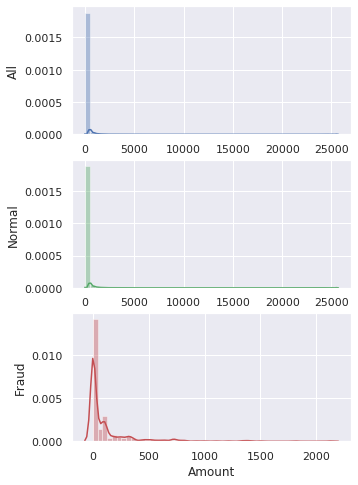

In [0]:
fig, ax = plt.subplots(3, 1, figsize=(5,8))
sns.distplot(df.Amount, ax=ax[0])
ax[0].set_ylabel('All')
sns.distplot(not_fraud.Amount, ax=ax[1], color='g')
ax[1].set_ylabel('Normal')
sns.distplot(fraud.Amount, ax=ax[2], color='r')
ax[2].set_ylabel('Fraud')
plt.show()

Though the starting time in the dataset is unknown, we can visualize the time to see if the fraudulent and normal transactions occur during certain time frames. 

The plot below shows the density plot of the time variable. The bi-modal shape of the distribution is due to the two-day period in the dataset. In each 24-hour period, the number of transactions is the highest in the middle. However, the time of transaction does not appear to matter for the type of transactions.

In [0]:
df.groupby(['Class'])['Time'].describe().T

Class,0,1
count,284315.000000,492.000000
mean,94838.202258,80746.806911
std,47484.015786,47835.365138
min,0.000000,406.000000
25%,54230.000000,41241.500000
50%,84711.000000,75568.500000
75%,139333.000000,128483.000000
max,172792.000000,170348.000000


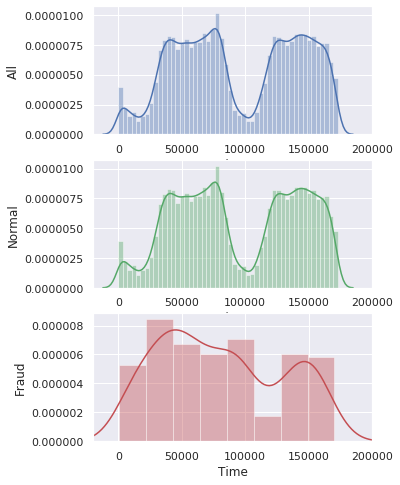

In [0]:
fig, ax = plt.subplots(3, 1, figsize=(5,8))
sns.distplot(df.Time, ax=ax[0])
ax[0].set_ylabel('All')
sns.distplot(not_fraud.Time, ax=ax[1], color='g')
ax[1].set_ylabel('Normal')
sns.distplot(fraud.Time, ax=ax[2], color='r')
ax[2].set_ylabel('Fraud')
ax = list(map(lambda x: x.set_xlim([-20000, 200000]), ax))
#ax[2].set_xlim([-20000, 200000])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


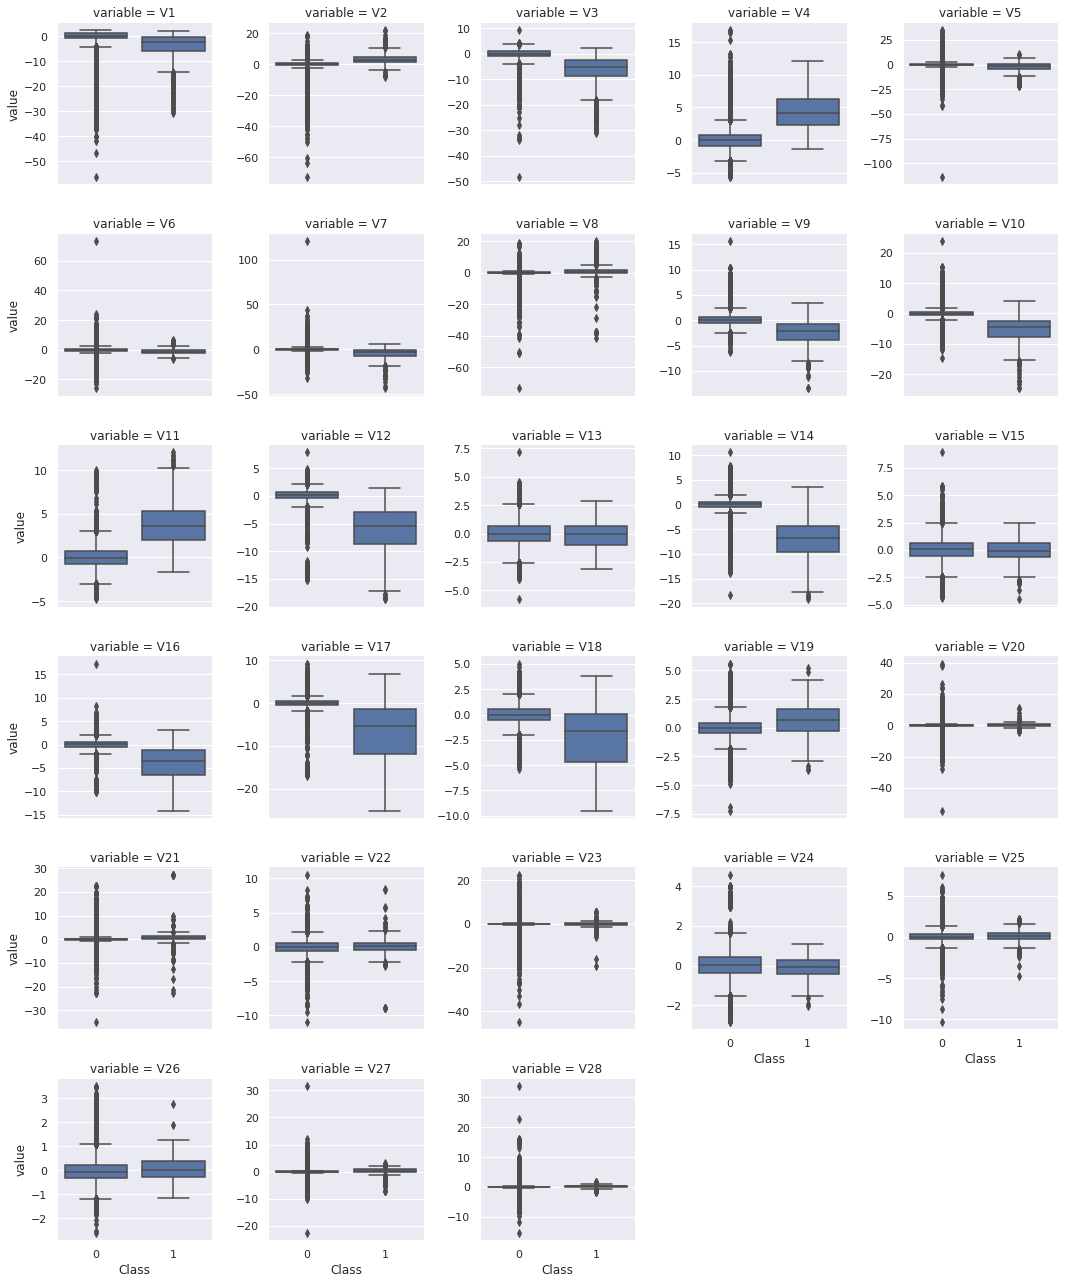

In [0]:
dfm = df.melt(id_vars=['Class'])
cols = df.columns[1:29]
g = sns.axisgrid.FacetGrid(dfm[dfm.variable.isin(cols)], col='variable', col_wrap=5, sharey=False)
#g = sns.FacetGrid(dfm, col='columns',col_wrap=5)
g = (g.map(sns.boxplot,'Class', 'value'))
plt.show()

The heatmap of the all the variables shows that the variables V1 to V28 are not correlated as expected, since they resulted from a PCA transformation.

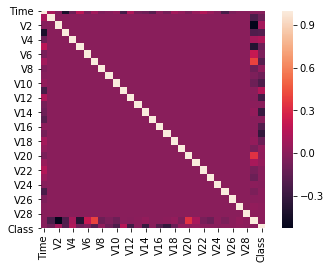

In [0]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, vmax=1, square=True)
plt.show()

In [0]:
corr_matrix
#V3 and time = -0.419618
#V2 and amount = -0.5314089

In [0]:
df.V1.nunique()

275663

### Modeling

5 different pre-processing pipelines were evaluated, as shown below. XGBoost models were fitted using the pre-processed data.

1.   Standardize (Robust) -> Weighted Classes -> Model
2.   Standardize (Robust) -> SMOTE -> Model
3.   Standardize -> SMOTE -> Model
4.   Standardize(Robust) -> Simple Random Undersample -> Model
5.   Standardize(Robust) -> Model

Note: Throughout the model fitting process, Pickle was used to save the fitted models.

A k-fold cross-validation approach was used to fit the models. The metrics used to evaluate the models were AUC, precision, and recall. The average scores across the cross-validation process at each pipeline were calculated. Here, the cross-validation scores were used to estimate the test scores.  


In [0]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,classification_report
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import KFold
from imblearn.pipeline import Pipeline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
X = df.drop(['Class'], axis=1, inplace=False)
y = df.Class

In [0]:
#instantiate the xgboost model and definie the pipelines
xgb_model = XGBClassifier(random_state=42)
xgb_model1 = XGBClassifier(random_state=42, scal_pos_weight=90)
undersampler = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)

#remove outliers from model1
model1_steps = [("RobustScaler", RobustScaler()), 
                ("xgboost", xgb_model1)]

model2_steps = [("RobustScaler", RobustScaler()), 
                ("SMOTE", smote), 
                ("xgboost", xgb_model)]

model3_steps = [("StandardScaler", StandardScaler()), 
                ("SMOTE", smote), 
                ("xgboost", xgb_model)]
              
model4_steps = [("RobustScaler", RobustScaler()), 
                ("UnderSampler", undersampler), 
                ("xgboost", xgb_model)]

model5_steps = [("RobustScaler", RobustScaler()), 
                ("xgboost", xgb_model)]

scoring  = {"Accuracy": "accuracy", 
            "Sensitivity": "recall", 
            "True Positive Rate":"precision",
            "AUC":"roc_auc"}

In [0]:
# Define a function to calculate the average scores
def get_avg_score(cv_score):
    for key, val in cv_score.items():
        print("Mean {}: {}".format(key, np.mean(val)))

In [0]:
#model 5
pipeline5 = Pipeline(model5_steps)
kf5 = KFold(n_splits=5, random_state=42)
cv_score5 = cross_validate(pipeline5, X, y, cv=kf5, scoring=scoring ,return_train_score=True)
cv_score5

{'fit_time': array([54.44827747, 54.49210858, 54.12898326, 54.56128192, 54.42774463]),
 'score_time': array([0.70450616, 0.6954546 , 0.75785184, 0.72554588, 0.68797231]),
 'test_AUC': array([0.98845301, 0.96678501, 0.98872564, 0.97662576, 0.98289808]),
 'test_Accuracy': array([0.99899933, 0.99957867, 0.99929777, 0.99963133, 0.99950844]),
 'test_Sensitivity': array([0.87898089, 0.73809524, 0.75630252, 0.70175439, 0.70666667]),
 'test_True Positive Rate': array([0.78409091, 0.96875   , 0.89108911, 0.90909091, 0.89830508]),
 'train_AUC': array([0.9968605 , 0.99800559, 0.99685148, 0.99760955, 0.99767781]),
 'train_Accuracy': array([0.99967083, 0.99966644, 0.99969277, 0.99964889, 0.999684  ]),
 'train_Sensitivity': array([0.80597015, 0.84558824, 0.83378016, 0.84597701, 0.84892086]),
 'train_True Positive Rate': array([0.96428571, 0.96368715, 0.97492163, 0.96587927, 0.97520661])}

In [0]:
get_avg_score(cv_score5)

Mean fit_time: 54.41167917251587
Mean score_time: 0.7142661571502685
Mean test_Accuracy: 0.9994031053598098
Mean train_Accuracy: 0.9996725852876669
Mean test_Sensitivity: 0.7563599406909931
Mean train_Sensitivity: 0.8360472840418727
Mean test_True Positive Rate: 0.8902652023676945
Mean train_True Positive Rate: 0.9687960743759717
Mean test_AUC: 0.9806974990109263
Mean train_AUC: 0.9974009864614108


In [0]:
#model 4
pipeline4 = Pipeline(model4_steps)
kf4 = KFold(n_splits=5, random_state=42)
cv_score4 = cross_validate(pipeline4, X, y, cv=kf4, scoring=scoring, return_train_score=True)
cv_score4

{'fit_time': array([0.53455997, 0.53406858, 0.51946163, 0.54911709, 0.52849674]),
 'score_time': array([0.76194477, 0.81784153, 0.80636191, 0.83091044, 0.84082651]),
 'test_AUC': array([0.98813317, 0.95299463, 0.98101652, 0.97724515, 0.99051471]),
 'test_Accuracy': array([0.95647976, 0.97784488, 0.96616984, 0.96453714, 0.98182967]),
 'test_Sensitivity': array([0.96178344, 0.8452381 , 0.93277311, 0.89473684, 0.88      ]),
 'test_True Positive Rate': array([0.05754573, 0.05378788, 0.0546798 , 0.02469734, 0.06043956]),
 'train_AUC': array([0.99763369, 0.99874462, 0.99813797, 0.99882449, 0.99882818]),
 'train_Accuracy': array([0.96006057, 0.97078277, 0.964239  , 0.97389904, 0.97834502]),
 'train_Sensitivity': array([0.99701493, 1.        , 0.99463807, 0.9954023 , 0.99520384]),
 'train_True Positive Rate': array([0.03540761, 0.05774947, 0.04355994, 0.06788962, 0.07761362])}

In [0]:
get_avg_score(cv_score4)

Mean fit_time: 0.5331408023834229
Mean score_time: 0.811577033996582
Mean test_Accuracy: 0.9693722570719002
Mean train_Accuracy: 0.9694652799200657
Mean test_Sensitivity: 0.9029062972155005
Mean train_Sensitivity: 0.9964518261718517
Mean test_True Positive Rate: 0.050230062090432924
Mean train_True Positive Rate: 0.05644405108368909
Mean test_AUC: 0.9779808359139401
Mean train_AUC: 0.9984337905859615


In [0]:
#model 3
pipeline3 = Pipeline(model3_steps)
kf3 = KFold(n_splits=5, random_state=42)
cv_score3 = cross_validate(pipeline3, X, y, cv=kf3, scoring=scoring, return_train_score=True)
cv_score3

{'fit_time': array([119.73437572, 118.54130077, 115.98517585, 114.67794132,
        115.78477931]),
 'score_time': array([0.8120718 , 0.81647921, 0.83737087, 0.81251621, 0.86215878]),
 'test_AUC': array([0.98914428, 0.95531141, 0.97385595, 0.97821107, 0.98250806]),
 'test_Accuracy': array([0.98525333, 0.98653488, 0.97482488, 0.98788645, 0.99373255]),
 'test_Sensitivity': array([0.93630573, 0.82142857, 0.91596639, 0.84210526, 0.84      ]),
 'test_True Positive Rate': array([0.15046059, 0.08404385, 0.07110241, 0.06584362, 0.15441176]),
 'train_AUC': array([0.99811055, 0.99918531, 0.99852808, 0.99856296, 0.99804342]),
 'train_Accuracy': array([0.98822445, 0.9909061 , 0.98768905, 0.99051552, 0.98954118]),
 'train_Sensitivity': array([0.95820896, 0.97794118, 0.95978552, 0.96091954, 0.96402878]),
 'train_True Positive Rate': array([0.10735786, 0.16206336, 0.113723  , 0.16315379, 0.14512635])}

In [0]:
get_avg_score(cv_score3)

Mean fit_time: 116.94471459388733
Mean score_time: 0.8281193733215332
Mean test_Accuracy: 0.9856464184680407
Mean train_Accuracy: 0.9893752614753379
Mean test_Sensitivity: 0.871161190725033
Mean train_Sensitivity: 0.9641767943381948
Mean test_True Positive Rate: 0.10517244845838931
Mean train_True Positive Rate: 0.13828487225515182
Mean test_AUC: 0.975806154394015
Mean train_AUC: 0.9984860630497746


In [0]:
#model 2
pipeline2 = Pipeline(model2_steps)
kf2 = KFold(n_splits=5, random_state=42)
cv_score2 = cross_validate(pipeline2, X, y, cv=kf2, scoring=scoring, return_train_score=True)
cv_score2

{'fit_time': array([120.38875556, 120.29561687, 120.08294082, 118.89263916,
        117.93431044]),
 'score_time': array([0.83544326, 0.90332913, 0.89504671, 0.87263632, 0.89375138]),
 'test_AUC': array([0.98963618, 0.95428457, 0.97625343, 0.97835043, 0.98553048]),
 'test_Accuracy': array([0.98456866, 0.98256733, 0.96796053, 0.97363108, 0.99410123]),
 'test_Sensitivity': array([0.94267516, 0.82142857, 0.92436975, 0.89473684, 0.82666667]),
 'test_True Positive Rate': array([0.1453831 , 0.06590258, 0.05711319, 0.03296703, 0.16103896]),
 'train_AUC': array([0.99818359, 0.99899347, 0.99861945, 0.99858937, 0.99859745]),
 'train_Accuracy': array([0.98790406, 0.99021264, 0.98831228, 0.9900898 , 0.98922079]),
 'train_Sensitivity': array([0.95820896, 0.96813725, 0.97319035, 0.95632184, 0.96402878]),
 'train_True Positive Rate': array([0.10479922, 0.15122511, 0.12035809, 0.1566855 , 0.14139993])}

In [0]:
get_avg_score(cv_score2)

Mean fit_time: 119.51885256767272
Mean score_time: 0.8800413608551025
Mean test_Accuracy: 0.9805657655729872
Mean train_Accuracy: 0.9891479140443125
Mean test_Sensitivity: 0.8819753974670659
Mean train_Sensitivity: 0.9639774349420375
Mean test_True Positive Rate: 0.09248097297652035
Mean train_True Positive Rate: 0.13489357004096142
Mean test_AUC: 0.9768110167228905
Mean train_AUC: 0.9985966653835984


In [0]:
#model 1
pipeline1 = Pipeline(model1_steps)
kf1 = KFold(n_splits=5, random_state=42)
cv_score1 = cross_validate(pipeline1, X, y, cv=kf1, scoring=scoring, return_train_score=True)
cv_score1

{'fit_time': array([54.48619366, 54.40114951, 54.68480158, 54.78532338, 54.42747617]),
 'score_time': array([0.72164512, 0.69928908, 0.75561619, 0.71442771, 0.67662001]),
 'test_AUC': array([0.98845301, 0.96678501, 0.98872564, 0.97662576, 0.98289808]),
 'test_Accuracy': array([0.99899933, 0.99957867, 0.99929777, 0.99963133, 0.99950844]),
 'test_Sensitivity': array([0.87898089, 0.73809524, 0.75630252, 0.70175439, 0.70666667]),
 'test_True Positive Rate': array([0.78409091, 0.96875   , 0.89108911, 0.90909091, 0.89830508]),
 'train_AUC': array([0.9968605 , 0.99800559, 0.99685148, 0.99760955, 0.99767781]),
 'train_Accuracy': array([0.99967083, 0.99966644, 0.99969277, 0.99964889, 0.999684  ]),
 'train_Sensitivity': array([0.80597015, 0.84558824, 0.83378016, 0.84597701, 0.84892086]),
 'train_True Positive Rate': array([0.96428571, 0.96368715, 0.97492163, 0.96587927, 0.97520661])}

In [0]:
get_avg_score(cv_score1)

Mean fit_time: 54.556988859176634
Mean score_time: 0.7135196208953858
Mean test_Accuracy: 0.9994031053598098
Mean train_Accuracy: 0.9996725852876669
Mean test_Sensitivity: 0.7563599406909931
Mean train_Sensitivity: 0.8360472840418727
Mean test_True Positive Rate: 0.8902652023676945
Mean train_True Positive Rate: 0.9687960743759717
Mean test_AUC: 0.9806974990109263
Mean train_AUC: 0.9974009864614108


Based on the result above, models 2, 5, and 6 had the best performance. Next, we perform a grid search to find the optimal values for the hyperparameters:

- Learning Rate: Parameter related to optimization algorithm
- Max Depth: Maximum tree depth for base learners
- Min Child Weight: Minimum sum of instance weight(hessian) needed in a child

In [0]:
#model 5
parameters = {'xgboost__learning_rate':[0.05],
              'xgboost__max_depth':range(3,10,2),
              'xgboost__min_child_weight':range(1,6,2),
              'xgboost__subsample':[0.8],
              'xgboost__colsample_bytree':[0.8], 
              'xgboost__eval_metric':['auc']}
pipeline5 = Pipeline(model5_steps)
gridsearch5 = GridSearchCV(pipeline5, param_grid=parameters, cv=5,  return_train_score=True, scoring=scoring, refit='AUC')
gridsearch5.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('RobustScaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('xgboost',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
     

In [0]:
# Use pickle to save model 
#import pickle
#path = '/content/drive/My Drive/Data Mining 1/gridsearch5.pickle'
#with open(path, 'wb') as f:
#  pickle.dump(gridsearch5, f)
#with open(path, 'rb') as f:
#    gridsearch5 = pickle.load(f)

In [0]:
#model 6
parameters = {'xgboost__learning_rate':[0.05],
              'xgboost__max_depth':range(3,10,2),
              'xgboost__min_child_weight':range(1,6,2),
              'xgboost__subsample':[0.8],
              'xgboost__colsample_bytree':[0.8], 
              'xgboost__eval_metric':['auc'],
              'xgboost__scale_pos_weight':[90,9]}
pipeline6 = Pipeline(model6_steps)
gridsearch6 = GridSearchCV(pipeline6, param_grid=parameters, cv=5,return_train_score=True, scoring=scoring, refit='AUC')
gridsearch6.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('RobustScaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('xgboost',
                                        XGBClassifier(base_score=0.5,
                                                      booster='gbtree',
                                                      colsample_bylevel=1,
                                                      colsample_bynode=1,
                                                      colsample_bytree=1,
                                                      gamma=0,
     

In [0]:
#import pickle
#path = '/content/drive/My Drive/Data Mining 1/gridsearch6.pickle'
#with open(path, 'wb') as f:
#   pickle.dump(gridsearch6, f)
#with open(path, 'rb') as f:
    gridsearch6 = pickle.load(f)

In [0]:
get_avg_score(cv_score6)

Mean fit_time: 50.431293964385986
Mean score_time: 0.9994587103525797
Mean test_Accuracy: 0.9989010116494429
Mean train_Accuracy: 0.9990660341607492
Mean test_Sensitivity: 0.8307175387929423
Mean train_Sensitivity: 0.9860418101126066
Mean test_True Positive Rate: 0.6491951320745366
Mean train_True Positive Rate: 0.6538113308349244


In [0]:
#model 2
pipeline2 = Pipeline(model2_steps)
kf2 = KFold(n_splits=3, random_state=42)
cv_score2 = cross_validate(pipeline2, X, y, cv=kf2, scoring=scoring, return_train_score=True)
cv_score2

{'fit_time': array([105.65234661, 106.63710189, 104.63247538]),
 'score_time': array([1.05316067, 1.09394336, 1.06701612]),
 'test_Accuracy': array([0.98923485, 0.98363108, 0.99785116]),
 'test_Sensitivity': array([0.9124424 , 0.86928105, 0.79508197]),
 'test_True Positive Rate': array([0.16486261, 0.07978404, 0.35144928]),
 'train_Accuracy': array([0.98832365, 0.99018808, 0.99113613]),
 'train_Sensitivity': array([0.97090909, 0.98525074, 0.97297297]),
 'train_True Positive Rate': array([0.10783522, 0.15237226, 0.17707821])}

In [0]:
parameters = {'xgboost__learning_rate':[0.05],
              'xgboost__max_depth':range(3,10,2),
              'xgboost__min_child_weight':range(1,6,2),
              'xgboost__subsample':[0.8],
              'xgboost__colsample_bytree':[0.8], 
              'xgboost__eval_metric':['auc']}
pipeline2 = Pipeline(model2_steps)
gridsearch2 = GridSearchCV(pipeline2, param_grid=parameters, cv=5, return_train_score=True,scoring=scoring, refit='AUC')
gridsearch2.fit(X,y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('RobustScaler',
                                        RobustScaler(copy=True,
                                                     quantile_range=(25.0,
                                                                     75.0),
                                                     with_centering=True,
                                                     with_scaling=True)),
                                       ('SMOTE',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=42, ratio=None,
                                              sampling_strategy='auto',
                                              s...
      

In [0]:
#import pickle
path = '/content/drive/My Drive/Data Mining 1/gridsearch2.pickle'
with open(path, 'wb') as f:
   pickle.dump(gridsearch2, f)
#with open(path, 'rb') as f:
#    gridsearch2 = pickle.load(f)

In [0]:
#model 3
pipeline3 = Pipeline(model3_steps)
kf3 = KFold(n_splits=3, random_state=42)
cv_score3 = cross_validate(pipeline3, X, y, cv=kf3, scoring=scoring, return_train_score=True)
cv_score3

{'fit_time': array([105.64349246, 106.42209744, 103.85131478]),
 'score_time': array([1.03961253, 1.07889318, 1.0885818 ]),
 'test_Accuracy': array([0.98918219, 0.98322027, 0.99796703]),
 'test_Sensitivity': array([0.9078341 , 0.8627451 , 0.80327869]),
 'test_True Positive Rate': array([0.16362126, 0.07746479, 0.3670412 ]),
 'train_Accuracy': array([0.98905573, 0.98934013, 0.99086753]),
 'train_Sensitivity': array([0.96727273, 0.98230088, 0.97027027]),
 'train_True Positive Rate': array([0.11391863, 0.14164185, 0.17243036])}

### Model Evaluation

In [0]:
#gridsearch5.grid_scores_
result6=gridsearch6.cv_results_

In [0]:
 def plot_score(gridsearch, parameter):
        plt.figure(figsize=(13, 13))
        plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)
        result = gridsearch.cv_results_
        plt.xlabel(parameter)
        plt.ylabel("Score")

    ax = plt.gca()
    ax.set_xlim(0, 10)
    ax.set_ylim(0.5, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(result['param_xgboost__'+parameter].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = result['mean_%s_%s' % (sample, scorer)]
            sample_score_std = result['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                          sample_score_mean + sample_score_std,
                          alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                  alpha=1 if sample == 'test' else 0.7,
                  label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(result['rank_test_%s' % scorer] == 1)[0][0]
        best_score = result['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
              linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                  (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid(False)
    plt.show()

In [0]:
def get_summary(gridsearch):
    result = gridsearch.cv_results_
    df = dict(mean_fit_time=np.mean(result['mean_fit_time']),
            mean_score_time=np.mean(result['mean_score_time']),
            mean_AUC_train=np.mean(result['mean_train_AUC']),
            mean_AUC_test=np.mean(result['mean_test_AUC']),
            mean_Sensitivity_train=np.mean(result['mean_train_Sensitivity']),
            mean_Sensitivity_test=np.mean(result['mean_test_Sensitivity']),
            mean_True_Positive_Rate_train=np.mean(result['mean_train_True Positive Rate']),
            mean_True_Positive_Rate_test=np.mean(result['mean_test_True Positive Rate']))
    return(df)

In [0]:
get_summary(gridsearch6)

{'mean_AUC_test': 0.9711362423754047,
 'mean_AUC_train': 0.9989244673835312,
 'mean_Sensitivity_test': 0.8317260006227697,
 'mean_Sensitivity_train': 0.9470033970111468,
 'mean_True_Positive_Rate_test': 0.644547639768463,
 'mean_True_Positive_Rate_train': 0.8599479068096922,
 'mean_fit_time': 87.87762895226479,
 'mean_score_time': 1.2907476564248401}

In [0]:
get_summary(gridsearch5)

{'mean_AUC_test': 0.9644571015666082,
 'mean_AUC_train': 0.9863418754865045,
 'mean_Sensitivity_test': 0.7757941523864588,
 'mean_Sensitivity_train': 0.8343370446433567,
 'mean_True_Positive_Rate_test': 0.8340786733141231,
 'mean_True_Positive_Rate_train': 0.9788130250229975,
 'mean_fit_time': 66.28847371737163,
 'mean_score_time': 0.6250222921371461}

In [0]:
get_summary(gridsearch2)

{'mean_AUC_test': 0.9726494202424797,
 'mean_AUC_train': 0.9987605456915946,
 'mean_Sensitivity_test': 0.8730283788476704,
 'mean_Sensitivity_train': 0.9784852731601675,
 'mean_True_Positive_Rate_test': 0.19668549074666233,
 'mean_True_Positive_Rate_train': 0.3058791472896693,
 'mean_fit_time': 177.5337320327759,
 'mean_score_time': 1.2708519776662193}